In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.spadl.api as spadl

In [2]:
## Configure file and folder names
datafolder = "../data"
statsbomb_json =  os.path.join(datafolder,"statsbomb-root","open-data-master","data")
statsbomb_h5 = os.path.join(datafolder,"statsbomb.h5")
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [3]:
spadl.statsbombjson_to_statsbombh5(statsbomb_json,statsbomb_h5)
# spadl.statsbombh5_to_spadlh5(statsbomb_h5,spadl_h5)

...Adding competitions to ../data/statsbomb.h5


...Adding players and teams to ../data/statsbomb.h5:   0%|          | 0/653 [00:00<?, ?it/s]

...Adding matches to ../data/statsbomb.h5


...Adding players and teams to ../data/statsbomb.h5: 100%|██████████| 653/653 [00:10<00:00, 63.80it/s] 
converting events files to ../data/statsbomb.h5: 100%|██████████| 653/653 [02:14<00:00,  4.86it/s]


In [4]:
tablenames = ["matches","players","teams","competitions"]
tables = {name : pd.read_hdf(statsbomb_h5,key=name) for name in tablenames}

match_id = tables["matches"].match_id[0]
tables["events"] = pd.read_hdf(statsbomb_h5,f"events/match_{match_id}")

for k,df in tables.items():
    print("#",k)
    print(df.columns,"\n")

# matches
Index(['away_score', 'away_team_gender', 'away_team_group', 'away_team_id',
       'away_team_name', 'competition_id', 'competition_name', 'country_name',
       'data_version', 'home_score', 'home_team_gender', 'home_team_group',
       'home_team_id', 'home_team_name', 'id', 'kick_off', 'last_updated',
       'managers', 'match_date', 'match_id', 'match_status', 'match_week',
       'name', 'season_id', 'season_name', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object') 

# players
Index(['country_id', 'country_name', 'extra', 'jersey_number', 'player_id',
       'player_name', 'player_nickname'],
      dtype='object') 

# teams
Index(['team_id', 'team_name'], dtype='object') 

# competitions
Index(['competition_gender', 'competition_id', 'competition_name',
       'country_name', 'match_available', 'match_updated', 'season_id',
       'season_name'],
      dtype='object') 

# events
Index(['counterpress', 'duration', 'extra', 'id', 'index', 'locati

In [5]:
spadl.statsbombh5_to_spadlh5(statsbomb_h5,spadl_h5)

  0%|          | 0/652 [00:00<?, ?game/s]

...Converting matches to games
...Converting players
...Converting teams
...Converting competitions
...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Computing playergames (minutes played in each game)


  0%|          | 0/652 [00:00<?, ?game/s]

...Converting events to actions


100%|██████████| 652/652 [03:58<00:00,  2.74game/s]


In [6]:
tablenames = ["games","players","teams","competitions","actiontypes","bodyparts","results"]
tables = {name : pd.read_hdf(spadl_h5,key=name) for name in tablenames}

game_id = tables["games"].game_id[0]
tables["actions"] = pd.read_hdf(spadl_h5,f"actions/game_{game_id}")

for k,df in tables.items():
    print("#",k)
    print(df.columns,"\n")

# games
Index(['away_score', 'away_team_gender', 'away_team_group', 'away_team_id',
       'away_team_name', 'competition_id', 'competition_name', 'country_name',
       'data_version', 'home_score', 'home_team_gender', 'home_team_group',
       'home_team_id', 'home_team_name', 'id', 'kick_off', 'last_updated',
       'managers', 'match_date', 'match_id', 'match_status', 'match_week',
       'name', 'season_id', 'season_name', 'shot_fidelity_version',
       'xy_fidelity_version', 'game_id'],
      dtype='object') 

# players
Index(['country_id', 'country_name', 'extra', 'jersey_number', 'player_id',
       'player_name', 'player_nickname'],
      dtype='object') 

# teams
Index(['team_id', 'team_name'], dtype='object') 

# competitions
Index(['competition_gender', 'competition_id', 'competition_name',
       'country_name', 'match_available', 'match_updated', 'season_id',
       'season_name'],
      dtype='object') 

# actiontypes
Index(['type_id', 'type_name'], dtype='object') 

# 

In [22]:
import matplotsoccer as mps
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

2018-07-14 Belgium 2-0 England 82'


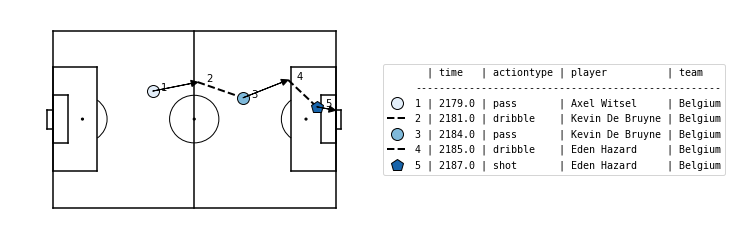

In [8]:
import matplotsoccer

tablenames = [
    "games",
    "players",
    "teams",
    "competitions",
    "actiontypes",
    "bodyparts",
    "results",
]
tables = {name: pd.read_hdf(spadl_h5, key=name) for name in tablenames}

# Select England vs Belgium game at World Cup
games = tables["games"].merge(tables["competitions"])
game_id = games[(games.competition_name == "FIFA World Cup") 
              & (games.away_team_name == "England")
              & (games.home_team_name == "Belgium")].game_id.values[0]

actions = pd.read_hdf(spadl_h5, f"actions/game_{game_id}")
actions = (
    actions.merge(tables["actiontypes"])
    .merge(tables["results"])
    .merge(tables["bodyparts"])
    .merge(tables["players"],"left",on="player_id")
    .merge(tables["teams"],"left",on="team_id")
    .sort_values(["period_id", "time_seconds", "timestamp"])
    .reset_index(drop=True)
)

# use nickname if available else use full name
actions["player"] = actions[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)

#shot = 128
shot = 2201
a = actions[shot-4:shot+1]

games = tables["games"]
g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
minute = int((a.period_id.values[0]-1)*45 +a.time_seconds.values[0] // 60) + 1
game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute}'"

print(game_info)

labels = a[["time_seconds", "type_name", "player", "team_name"]]
matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time","actiontype","player","team"],
    zoom=False,
    figsize=6
)

In [25]:
x,y = a.start_x, a.start_y

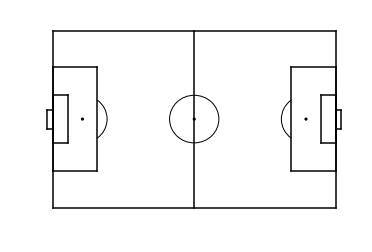

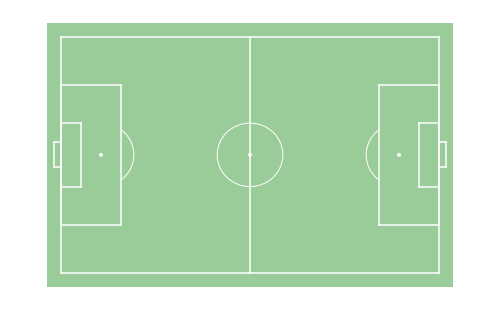

In [26]:
f = mps.field()
f = mps.field(color="green",figsize=8)

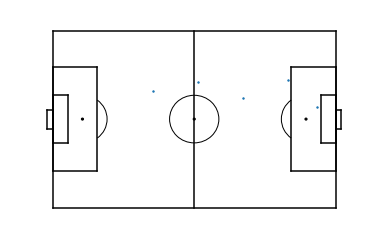

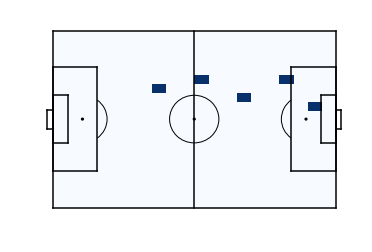

In [27]:
ax = mps.field(show=False)
ax.scatter(x,y,s=2); plt.show()

matrix = mps.count(x,y,n=20,m=20)
hm = mps.heatmap(matrix)

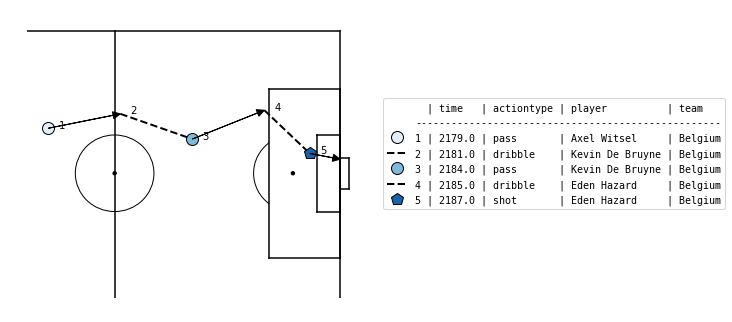

In [9]:
matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team=a.team_name,
    result=a.result_name == "success",
    label=labels,
    labeltitle=["time","actiontype","player","team"],
    zoom=True,
)

In [37]:
url1 = '../data/spadl-statsbomb.h5'
data1 = pd.read_hdf(spadl_h5, key='games')
data1[:5]

,away_score,away_team_gender,away_team_group,away_team_id,away_team_name,competition_id,competition_name,country_name,data_version,home_score,...,match_date,match_id,match_status,match_week,name,season_id,season_name,shot_fidelity_version,xy_fidelity_version,game_id
0,0,male,None,782,Belgium,43,FIFA World Cup,International,1.0.2,1,...,2018-07-10,8655,available,2,A. Cunha,3,2018,NaN,NaN,8655
1,0,male,None,768,England,43,FIFA World Cup,International,1.0.2,2,...,2018-07-14,8657,available,1,A. Faghani,3,2018,NaN,NaN,8657
2,1,male,Group B,772,Spain,43,FIFA World Cup,International,1.0.2,0,...,2018-06-20,7543,available,2,A. Cunha,3,2018,NaN,NaN,7543
3,2,male,Group C,784,Peru,43,FIFA World Cup,International,1.0.2,0,...,2018-06-26,7562,available,3,S. Karasev,3,2018,NaN,NaN,7562
4,0,male,Group D,793,Iceland,43,FIFA World Cup,International,1.0.2,2,...,2018-06-22,7549,available,2,M. Conger,3,2018,NaN,NaN,7549


In [38]:
def get_actions(games, hdf_url):
    actions = []
    for game in tqdm(list(games.itertuples())):
        a = pd.read_hdf(hdf_url, key="actions/game_" + str(game.game_id))
        a["left_to_right"] = a["team_id"] == game.home_team_id
        actions.append(a)
    actions = pd.concat(actions)

    actions = always_ltr(actions)

    actiontypes = pd.read_hdf(hdf_url, key="actiontypes")
    actions = actions.merge(actiontypes)

    return actions


def always_ltr(actions):
    away_idx = ~actions.left_to_right
    actions.loc[away_idx, "start_x"] = 105 - actions[away_idx].start_x.values
    actions.loc[away_idx, "start_y"] = 68 - actions[away_idx].start_y.values
    actions.loc[away_idx, "end_x"] = 105 - actions[away_idx].end_x.values
    actions.loc[away_idx, "end_y"] = 68 - actions[away_idx].end_y.values
    return actions

actions = get_actions(data1,url1)
players = pd.read_hdf(url1,key="players")
actions = actions.merge(players)

100%|██████████| 652/652 [00:17<00:00, 36.58it/s]


In [72]:
# actions.type_name[:-1]
actions[:-1]

,game_id,period_id,time_seconds,timestamp,team_id,player_id,start_x,start_y,end_x,end_y,...,bodypart_id,action_id,left_to_right,type_name,country_id,country_name,extra,jersey_number,player_name,player_nickname
0,8655,1,0.0,00:00:00.720,771,5487,52.058824,33.569620,30.000000,28.405063,...,0,0,True,pass,78.0,France,{},7,Antoine Griezmann,None
1,8655,1,592.0,00:09:52.960,771,5487,77.647059,39.594937,92.647059,65.417722,...,0,257,True,pass,78.0,France,{},7,Antoine Griezmann,None
2,8655,1,731.0,00:12:11.520,771,5487,30.000000,54.227848,33.529412,47.341772,...,0,338,True,pass,78.0,France,{},7,Antoine Griezmann,None
3,8655,1,855.0,00:14:15.280,771,5487,69.705882,58.531646,60.000000,63.696203,...,0,387,True,pass,78.0,France,{},7,Antoine Griezmann,None
4,8655,1,1032.0,00:17:12.920,771,5487,67.058824,45.620253,61.764706,38.734177,...,0,451,True,pass,78.0,France,{},7,Antoine Griezmann,None
5,8655,1,1505.0,00:25:05.680,771,5487,87.352941,58.531646,91.764706,67.139241,...,0,612,True,pass,78.0,France,{},7,Antoine Griezmann,None
6,8655,1,1919.0,00:31:59.800,771,5487,90.882353,58.531646,80.294118,65.417722,...,0,737,True,pass,78.0,France,{},7,Antoine Griezmann,None
7,8655,1,1921.0,00:32:01.933,771,5487,88.235294,56.810127,88.235294,66.278481,...,0,739,True,pass,78.0,France,{},7,Antoine Griezmann,None
8,8655,1,1988.0,00:33:08.760,771,5487,64.411765,36.151899,94.411765,17.215190,...,0,757,True,pass,78.0,France,{},7,Antoine Griezmann,None
9,8655,1,2097.0,00:34:57.200,771,5487,75.882353,21.518987,86.470588,14.632911,...,0,795,True,pass,78.0,France,{},7,Antoine Griezmann,None


In [116]:
pa = actions[actions.type_name.str.contains("shot")]
# pa[:4]
set(pa.player_name)
# actions[:4]

{'Gabriel Alejandro Milito',
 'Gianluca Zambrotta',
 'Emilio José Viqueira Moure',
 'Jessica Park',
 'Raúl Tamudo Montero',
 'Yussuf Yurary Poulsen',
 'Mark Dennis González Hoffmann',
 'Maren Nævdal Mjelde',
 'Paulo Assunção da Silva',
 'Emiliano Buendía',
 'Iván Ramis Barrios',
 'Salvador Ballesta Vialcho',
 'Eduardo Nascimento Costa',
 'Deneisha Selena Blackwood',
 'Rose Lavelle',
 'Daniel González Benítez',
 'Gabrielle George',
 'Marcos Gullón Ferrera',
 'Hirving Rodrigo Lozano Bahena',
 'Courtney Sweetman-Kirk',
 'Kieran Trippier',
 'Alex Greenwood',
 'Michael Krohn-Dehli',
 'Aritz Aduriz Zubeldia',
 'Víctor Sánchez Mata',
 'Enrique Fernando Ortiz Moruno',
 'Ebi Smolarek',
 'Alanna Kennedy',
 'Gaelle Enganamouit',
 'Xabier Alonso Olano',
 'Jesús Daniel Gallardo Vasconcelos',
 'Nabil Fekir',
 'Raúl García Escudero',
 'Mathew Leckie',
 'Christen Westphal',
 'Manuel Rolando Iturra Urrutia',
 'Margaret Purce',
 'Mariona Caldentey Oliver',
 'Javier Pedro Saviola Fernández',
 'Omid Ebrah

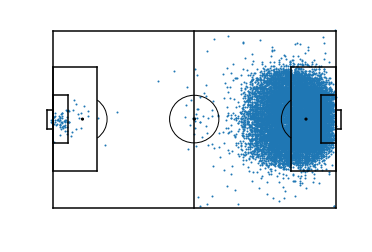

In [117]:
ax = mps.field(show=False)
ax.scatter(pa.start_x,pa.start_y,s=1)

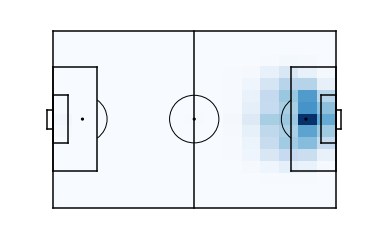

In [118]:
import matplotlib.pyplot as plt
hm = mps.count(pa.start_x,pa.start_y,n=15,m=15)
mps.heatmap(matrix=hm)

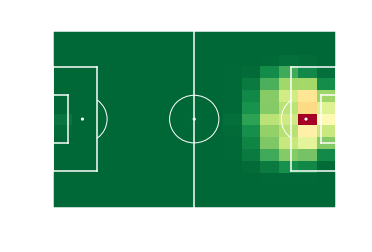

In [119]:
mps.heatmap_green(matrix=hm)